In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm
import sys
sys.path.append("../src")
from event_selections import *

In [4]:
pd.set_option('display.max_columns', None)

In [3]:
def drop_columns(df):
    #kept_columns=['layer', 'strip', 'pedestal', 'pf_event', 'adc_sum_end0', 'adc_sum_end1', 'end', 'mpv', 'std_dev']
    #df=df[df.columns.intersection(kept_columns)]
    return df

def import_data(calibration_folder, data_folder, run_n):
    pedestals=drop_columns(pd.read_csv(calibration_folder+"/pedestals_MIP.csv", sep=','))
    mips=drop_columns(pd.read_csv(calibration_folder+"/mip.csv", sep=','))
    run=drop_columns(pd.read_csv(data_folder+"/run_"+str(run_n)+"_pulse.csv", sep=','))
    # run=run.astype({"adc_sum_end0":float,"adc_sum_end1":float}) 
    return pedestals,mips,run

In [5]:
def drop_empty(df):
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestal_df,layer,strip)
            # for now, we don't deal with conversion to MeV
            #mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                
                # check whetehr signal is large enough
                el=el[el["adc_sum_end0"]>(peds.iloc[0,3]+5*peds.iloc[0,5])] 
                el=el[el["adc_sum_end1"]>(peds.iloc[1,3]+5*peds.iloc[1,5])] 

                # subtract from sum
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,3]
                el.loc[:,"adc_sum_end1"]-=peds.iloc[1,3]
                
                # subtract from max
                el.loc[:,"adc_max_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_max_end1"]-=peds.iloc[1,6]

                # subtract from mean
                el.loc[:,"adc_mean_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_mean_end1"]-=peds.iloc[1,6]
                
                # miniped=peds.iloc[0,-2]/8
                # miniped1=peds.iloc[1,-2]/8

                # subtract from timestamps
                el.loc[:,"adc_0_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_1_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_2_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_3_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_4_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_5_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_6_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_7_end0"]-=peds.iloc[0,6]

                el.loc[:,"adc_0_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_1_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_2_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_3_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_4_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_5_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_6_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_7_end1"]-=peds.iloc[1,6]
                
                data.extend(el.values.tolist())
                
    names=list(df.columns)

    df_s=pd.DataFrame(data, columns=names)
    
    return df_s

In [107]:
c_folder="../../data/calibration"
d_folder="../../data/runData"
r_n=307
pulsed=True
p_folder="../../plots/run_"+str(r_n)

In [108]:
pedestal_df, mip_df, run_df=import_data(c_folder, d_folder,r_n)
run_df=run_df.drop(columns=['toa_end0', 'toa_end1'])
run_df=drop_empty(run_df)

In [110]:
pulse_df=pd.read_csv(d_folder+"/run_"+str(r_n)+"_pulse_problems.csv", index_col="index")

In [111]:
pulse_df.head()

,layer,bar,event,has_problem,problem_type
index,,,,,
0,1.0,0.0,36.0,0,NaN
1,1.0,0.0,91.0,0,NaN
2,1.0,0.0,175.0,0,NaN
3,1.0,0.0,277.0,0,NaN
4,1.0,0.0,368.0,0,NaN


In [112]:
run_df.head()

,pf_event,tot_end0,adc_sum_end0,adc_mean_end0,adc_max_end0,adc_0_end0,adc_1_end0,adc_2_end0,adc_3_end0,adc_4_end0,adc_5_end0,adc_6_end0,adc_7_end0,layer,strip,pf_spill,pf_ticks,tot_end1,adc_sum_end1,adc_mean_end1,adc_max_end1,adc_0_end1,adc_1_end1,adc_2_end1,adc_3_end1,adc_4_end1,adc_5_end1,adc_6_end1,adc_7_end1
0,36.0,0.0,410.0,51.250,85.0,4.0,24.0,64.0,85.0,84.0,64.0,48.0,37.0,1.0,0.0,1.0,773324.0,0.0,484.0,60.500,104.0,6.0,29.0,74.0,104.0,102.0,78.0,53.0,38.0
1,91.0,0.0,505.0,63.125,100.0,6.0,40.0,78.0,96.0,100.0,80.0,59.0,46.0,1.0,0.0,1.0,973549.0,0.0,520.0,65.000,109.0,2.0,34.0,78.0,102.0,109.0,89.0,64.0,42.0
2,175.0,0.0,1126.0,140.750,207.0,31.0,120.0,198.0,207.0,199.0,168.0,140.0,63.0,1.0,0.0,1.0,1269484.0,0.0,1133.0,141.625,221.0,32.0,126.0,195.0,221.0,204.0,158.0,132.0,65.0
3,277.0,0.0,74.0,9.250,16.0,0.0,2.0,8.0,12.0,16.0,15.0,10.0,11.0,1.0,0.0,1.0,1644282.0,0.0,79.0,9.875,16.0,0.0,5.0,8.0,14.0,16.0,14.0,12.0,10.0
4,368.0,0.0,361.0,45.125,70.0,3.0,18.0,46.0,64.0,70.0,64.0,54.0,42.0,1.0,0.0,1.0,2104424.0,0.0,706.0,88.250,150.0,2.0,46.0,100.0,142.0,150.0,134.0,86.0,46.0


In [113]:
filtered_df=run_df.drop(["pf_event", "layer", "strip", "pf_spill", "pf_ticks"], axis=1)

In [114]:
big_df=filtered_df.merge(pulse_df, left_index=True, right_index=True)

In [115]:
big_df.drop(list(big_df.filter(regex = 'adc_.?_end0')), axis = 1, inplace = True)
big_df.drop(list(big_df.filter(regex = 'adc_.?_end1')), axis = 1, inplace = True)

In [116]:
wavy=big_df[big_df["problem_type"]=="WAVE"][["adc_sum_end0", "adc_sum_end1"]]
late=big_df[big_df["problem_type"]=="LATE"][["adc_sum_end0", "adc_sum_end1"]]
spiky=big_df[(big_df["problem_type"]=="SPIKE_0") | (big_df["problem_type"]=="SPIKE_1")][["adc_sum_end0", "adc_sum_end1"]]

In [117]:
good=big_df[big_df["has_problem"]==0][["adc_sum_end0", "adc_sum_end1"]]

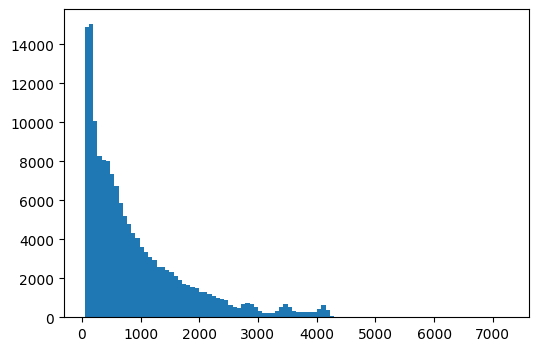

In [118]:
plt.rcParams["figure.figsize"]=(6,4)
plt.hist(good["adc_sum_end0"], bins=hand_bins)
plt.show()

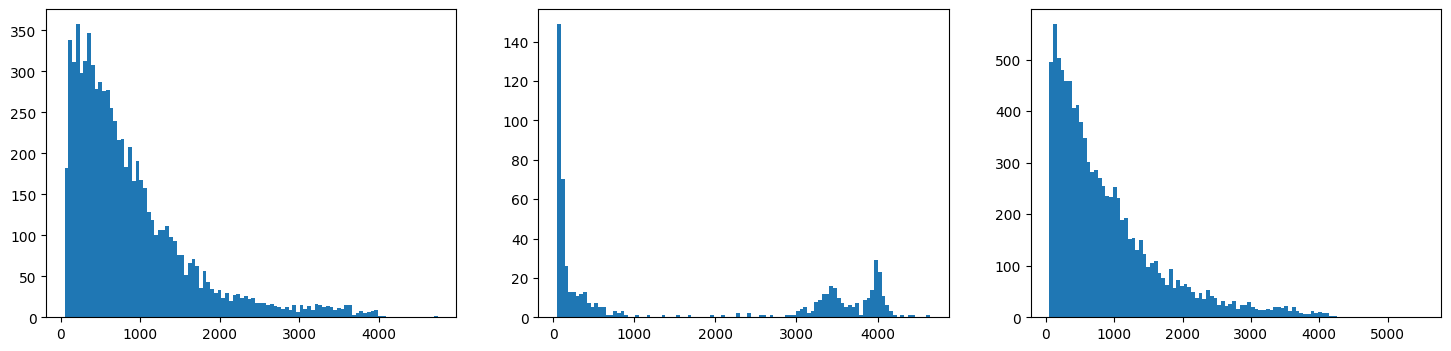

In [119]:
plt.rcParams["figure.figsize"]=(18,4)

plt.subplot(1,3,1)
plt.hist(wavy["adc_sum_end0"], bins=100)

plt.subplot(1,3,2)
plt.hist(late["adc_sum_end0"], bins=100)

plt.subplot(1,3,3)
plt.hist(spiky["adc_sum_end0"], bins=100)

plt.show()

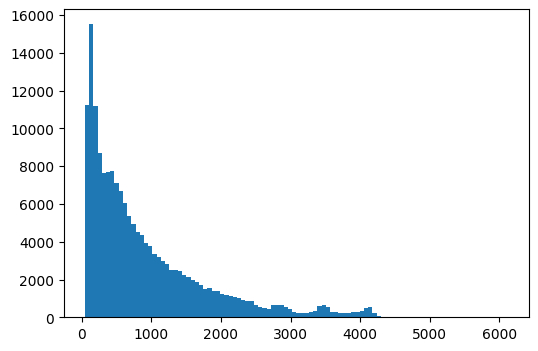

In [120]:
plt.rcParams["figure.figsize"]=(6,4)

plt.hist(big_df["adc_sum_end0"], bins=100)
plt.show()

In [121]:
hand_bins=np.linspace(50,7250,101)

a,_=np.histogram(big_df["adc_sum_end0"], bins=hand_bins)
w,_=np.histogram(wavy["adc_sum_end0"], bins=hand_bins)
l,_=np.histogram(late["adc_sum_end0"], bins=hand_bins)
s,_=np.histogram(spiky["adc_sum_end0"], bins=hand_bins)

In [122]:
wavy_share=w/a
late_share=l/a
spiky_share=s/a

/tmp/ipykernel_6777/2869659217.py:1: RuntimeWarning: invalid value encountered in divide
  wavy_share=w/a
/tmp/ipykernel_6777/2869659217.py:2: RuntimeWarning: invalid value encountered in divide
  late_share=l/a
/tmp/ipykernel_6777/2869659217.py:3: RuntimeWarning: invalid value encountered in divide
  spiky_share=s/a


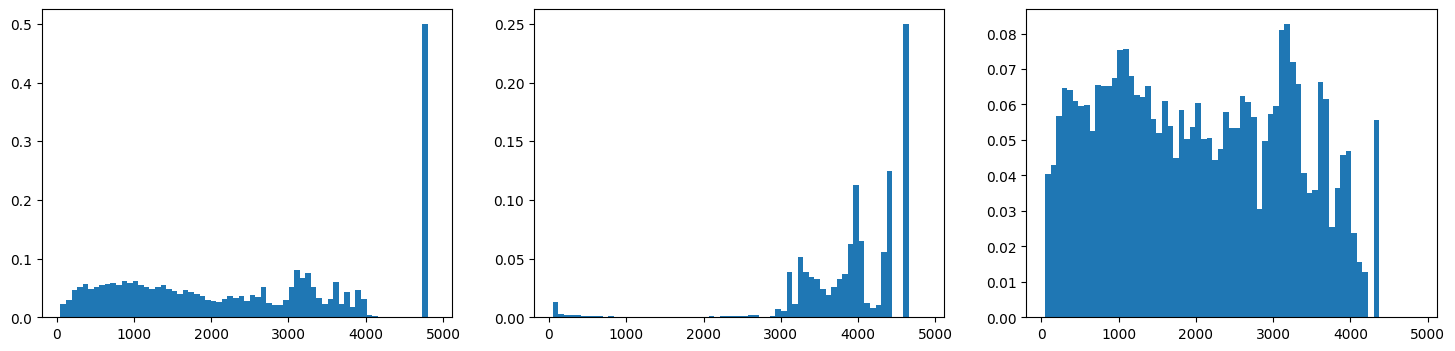

In [123]:
plt.rcParams["figure.figsize"]=(18,4)

plt.subplot(1,3,1)
plt.hist(hand_bins[:-1],hand_bins,weights= wavy_share)

plt.subplot(1,3,2)
plt.hist(hand_bins[:-1],hand_bins,weights= late_share)

plt.subplot(1,3,3)
plt.hist(hand_bins[:-1],hand_bins,weights= spiky_share)

plt.show()

In [41]:
big_df.head()

,tot_end0,adc_sum_end0,adc_mean_end0,adc_max_end0,tot_end1,adc_sum_end1,adc_mean_end1,adc_max_end1,layer,bar,event,has_problem,problem_type
0,0.0,135.0,16.875,58.0,0.0,129.0,16.125,58.0,1.0,0.0,341.0,1,WAVE
1,0.0,64.0,8.000,50.0,0.0,188.0,23.500,50.0,1.0,0.0,444.0,1,SPIKE_0
2,0.0,131.0,16.375,45.0,0.0,126.0,15.750,45.0,1.0,0.0,501.0,0,NaN
3,656.0,4166.0,520.750,928.0,384.0,2733.0,341.625,918.0,1.0,0.0,878.0,0,NaN
4,0.0,104.0,13.000,38.0,0.0,84.0,10.500,36.0,1.0,0.0,1024.0,1,WAVE


In [126]:
big_df.groupby(["problem_type"]).count()

,tot_end0,adc_sum_end0,adc_mean_end0,adc_max_end0,tot_end1,adc_sum_end1,adc_mean_end1,adc_max_end1,layer,bar,event,has_problem
problem_type,,,,,,,,,,,,
LATE,604,604,604,604,604,604,604,604,604,604,604,604
SPIKE_0,4926,4926,4926,4926,4926,4926,4926,4926,4926,4926,4926,4926
SPIKE_1,4792,4792,4792,4792,4792,4792,4792,4792,4792,4792,4792,4792
WAVE,7688,7688,7688,7688,7688,7688,7688,7688,7688,7688,7688,7688


In [127]:
big_df.groupby(["has_problem"]).count()

,tot_end0,adc_sum_end0,adc_mean_end0,adc_max_end0,tot_end1,adc_sum_end1,adc_mean_end1,adc_max_end1,layer,bar,event,problem_type
has_problem,,,,,,,,,,,,
0,154261,154261,154261,154261,154261,154261,154261,154261,154261,154261,154261,0
1,18010,18010,18010,18010,18010,18010,18010,18010,18010,18010,18010,18010


In [128]:
18010/(18010+154261)

0.1045445838243233